In [63]:
from raw_python.Bagging import create_models, create_bags, evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import random
from raw_python.BaggingSA import BaggingSA
from typing import Literal, Tuple
from raw_python.Bagging import predict
import sklearn
from raw_python.plots_manager import *
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from tabulate import tabulate
import seaborn as sns
from scipy.stats import *


# PARAMS

+---------------+------+-------+-------+--------------------+---------------------+----------------------+
|    dataset    | beta | gamma | delta |      accuracy      |    fitness_norm     |    spearman_corr     |
+---------------+------+-------+-------+--------------------+---------------------+----------------------+
| breast_cancer | 0.5  | 0.75  | 0.05  | 0.956080304671854  | 0.48189137153569445 |  0.1209434347881912  |
|    digits     | 0.75 | 0.25  | 0.05  | 0.9410092386373009 | 0.7845301783264746  |  0.2728745674572367  |
|     pima      | 0.5  |  0.5  | 0.05  | 0.7261284722222222 | 0.6131031706369038  | 0.009396479192946847 |
|     wine      | 0.75 | 0.75  | 0.05  | 0.9681818181818181 | 0.7060013717421124  | 0.11416445282854253  |
+---------------+------+-------+-------+--------------------+---------------------+----------------------+


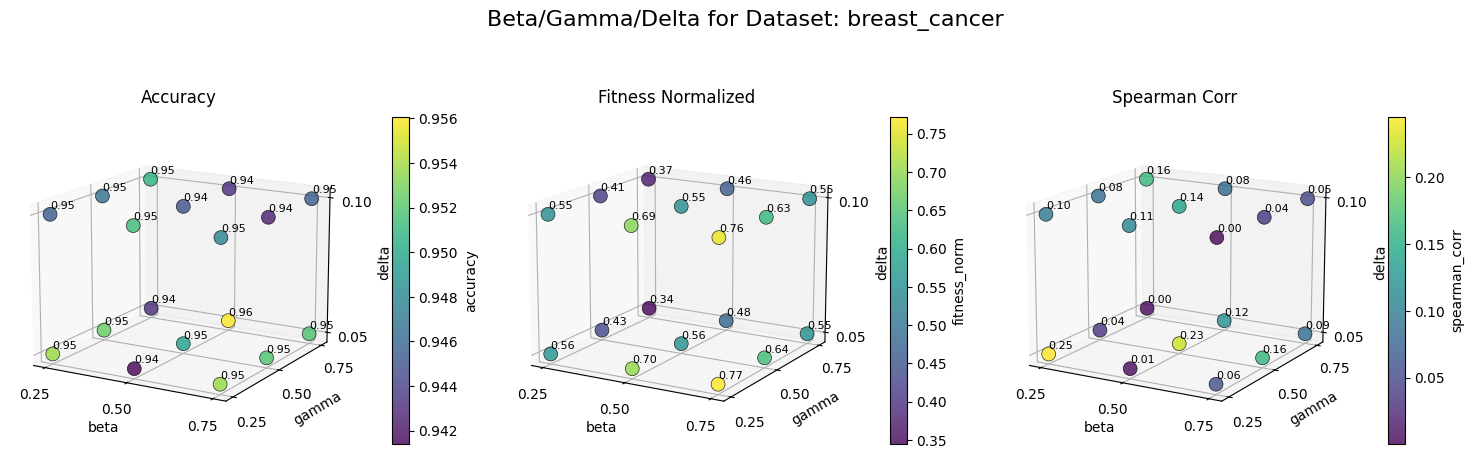

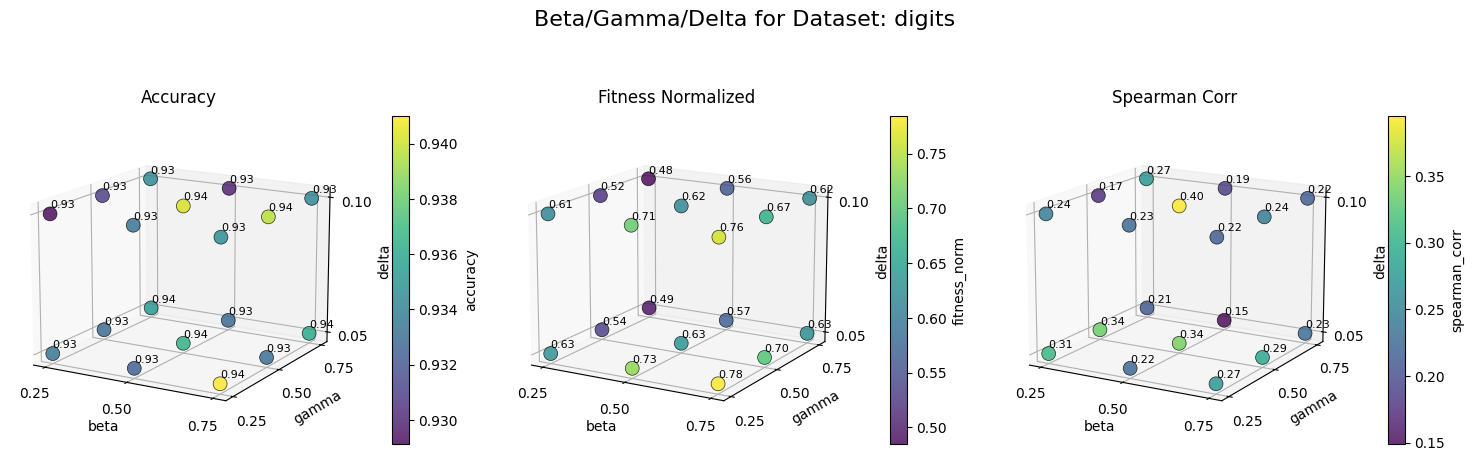

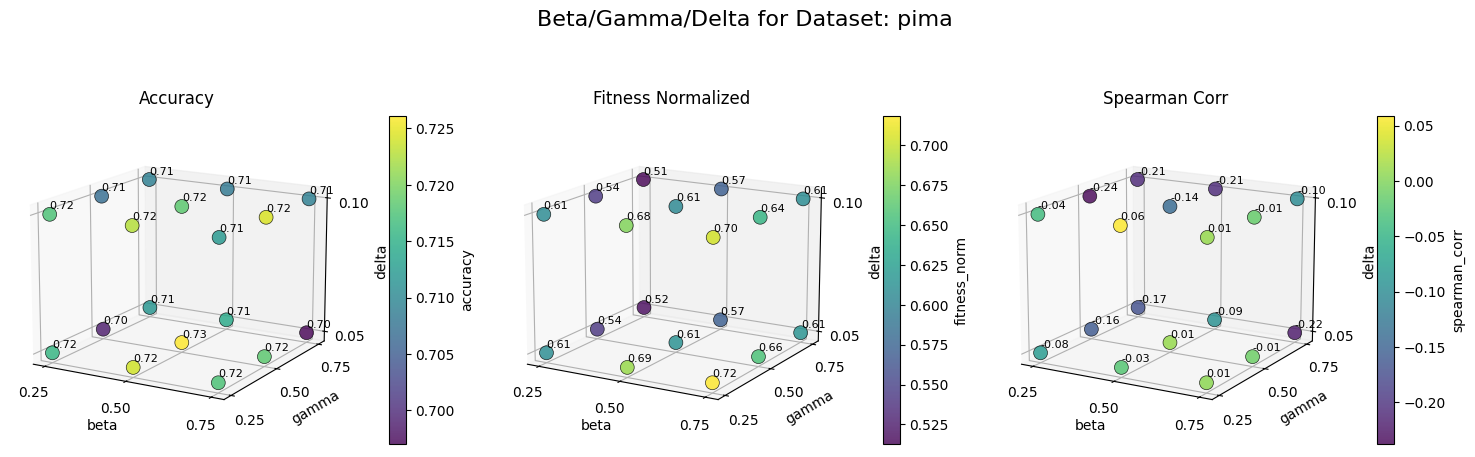

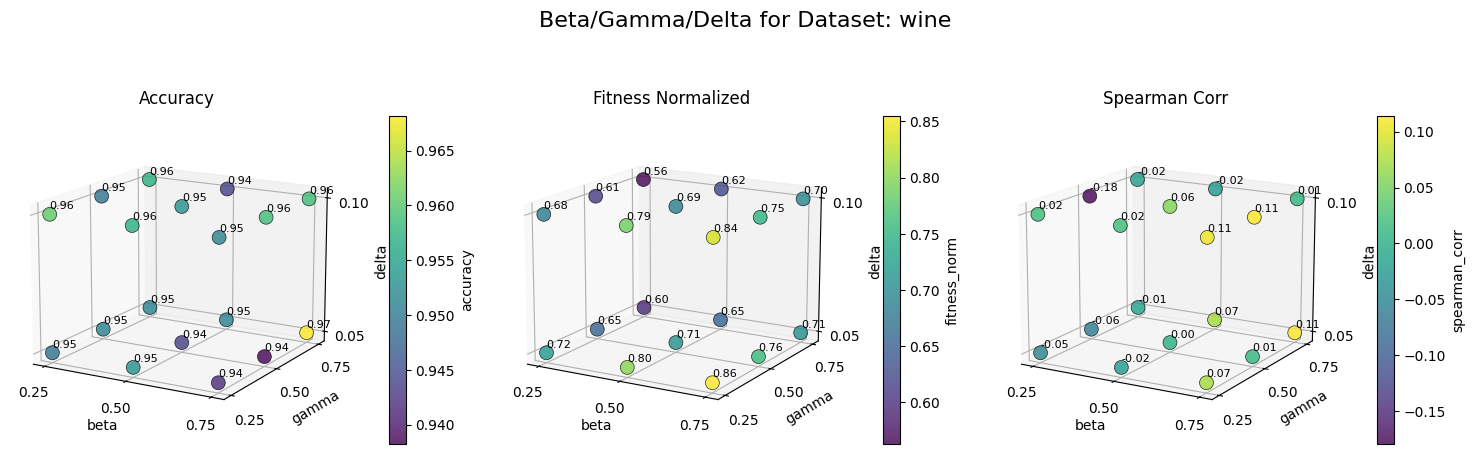

In [64]:
greeks = ['beta', 'gamma', 'delta']

files = glob.glob('./../res/params_*.csv')
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

df = df[df['delta'] != 0.01]

df['fitness_norm'] = (df['fitness'] + df['epsilon']) / (df['beta'] + df['gamma'] + df['epsilon'])

grouped = df.groupby(['dataset'] + greeks).agg({
    'accuracy': 'mean',
    'fitness_norm': 'mean',
    'spearman_corr': 'mean'
}).reset_index()

grouped_corr = df[df['spearman_p'] < 0.05].groupby(['dataset'] + greeks).agg({
    'accuracy': 'mean',
    'fitness_norm': 'mean',
    'spearman_corr': 'mean'
}).reset_index()


best_by_dataset = grouped.loc[grouped.groupby('dataset')['accuracy'].idxmax()]
print(tabulate(best_by_dataset, headers='keys', tablefmt='pretty', showindex=False))
best_by_dataset.to_csv('./../report/best_greeks_by_dataset.csv', index=False)

# 3D Scatter Plot Function
def plot_metrics_3d_subplots(df, dataset, metrics, titles, themes, path):
    fig = plt.figure(figsize=(15, 5))  # Adjust figure size for subplots
    fig.suptitle(f"Beta/Gamma/Delta for Dataset: {dataset}", fontsize=16, x=0.5)
    for i, (metric, title, theme) in enumerate(zip(metrics, titles, themes), start=1):
        df_tmp = df[df['dataset'] == dataset]
        ax = fig.add_subplot(1, 3, i, projection='3d')  # Create a subplot for each metric
        sc = ax.scatter(
            df_tmp[greeks[0]], 
            df_tmp[greeks[1]], 
            df_tmp[greeks[2]], 
            c=df_tmp[metric], 
            cmap=theme, 
            s=100, 
            depthshade=True,
            edgecolor='k',  # Add black edges to improve point visibility
            linewidth=0.5,
            alpha=0.8  # Slight transparency helps with overlapping points
        )
        ax.set_xlabel(greeks[0])
        ax.set_ylabel(greeks[1])
        ax.set_zlabel(greeks[2])
        ax.set_title(title)
        
        ax.set_xticks(df_tmp[greeks[0]].unique())
        ax.set_yticks(df_tmp[greeks[1]].unique())
        ax.set_zticks(df_tmp[greeks[2]].unique())
        
        # ax.grid(True, linestyle='--', alpha=0.5)
        # ax.view_init(elev=15, azim=30)
        ax.view_init(elev=15)
        
        # Adjust colorbar position and size
        cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.1)  # Shrink and add padding
        cbar.set_label(metric)
        
        # Add numeric annotations
        for _, row in df_tmp.iterrows():
            ax.text(row[greeks[0]], row[greeks[1]], row[greeks[2]]+.002, f"{row[metric]:.2f}", fontsize=8, color='black')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    if path != None:
        plt.savefig(path, bbox_inches='tight')
    plt.show()


datasets = grouped['dataset'].unique()

# Define metrics, titles, and themes for the subplots
metrics = ['accuracy', 'fitness_norm', 'spearman_corr']
titles = [
    'Accuracy',
    'Fitness Normalized',
    'Spearman Corr'
]
themes = ['viridis', 'viridis', 'viridis']

# Generate subplots for each dataset
for dataset in datasets:
    plot_metrics_3d_subplots(grouped, dataset, metrics, titles, themes, f'./../report/plot_{dataset}_greeks.png')

In [65]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.interpolate import griddata
# import numpy as np
# import math

# # Constants
# greeks = ['beta', 'gamma', 'delta']

# def plot_accuracy_surfaces_by_dataset(df):
#     datasets = df['dataset'].unique()

#     for dataset in datasets:
#         df_dataset = df[df['dataset'] == dataset]
#         delta_values = sorted(df_dataset['delta'].unique())
#         n = len(delta_values)

#         cols = min(n, 3)
#         rows = math.ceil(n / cols)

#         fig = plt.figure(figsize=(6 * cols, 5 * rows))
#         fig.suptitle(f"Accuracy Surface Plots for Dataset: {dataset}", fontsize=16)

#         for i, delta_val in enumerate(delta_values, start=1):
#             df_slice = df_dataset[df_dataset['delta'] == delta_val]
#             if df_slice.shape[0] < 4:
#                 continue

#             x = df_slice['beta']
#             y = df_slice['gamma']
#             z = df_slice['accuracy']

#             xi = np.linspace(x.min(), x.max(), 50)
#             yi = np.linspace(y.min(), y.max(), 50)
#             xi, yi = np.meshgrid(xi, yi)
#             zi = griddata((x, y), z, (xi, yi), method='cubic')

#             # Max accuracy point
#             max_row = df_slice.loc[df_slice['accuracy'].idxmax()]
#             max_acc = max_row['accuracy']
#             beta_max = max_row['beta']
#             gamma_max = max_row['gamma']

#             ax = fig.add_subplot(rows, cols, i, projection='3d')
#             surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')

#             ax.set_title(f"Delta = {delta_val:.3f}", fontsize=10)
#             ax.set_xlabel("Beta")
#             ax.set_ylabel("Gamma")
#             ax.set_zlabel("Accuracy")

#             ax.set_xticks(sorted(df_slice['beta'].unique()))
#             ax.set_yticks(sorted(df_slice['gamma'].unique()))
#             ax.view_init(elev=30, azim=135)


#         plt.tight_layout(rect=[0, 0, 1, 0.95])
#         plt.show()

# # Call the function
# plot_accuracy_surfaces_by_dataset(df)


In [66]:
# # Define a function to plot 3D scatter
# def plot_3d_metric(data, dataset, metric, title):
#     data = data[data['dataset'] == dataset]
#     fig = px.scatter_3d(
#         data, x=greeks[0], y=greeks[1], z=greeks[2],
#         color=metric, size_max=10,
#         title=title,
#         color_continuous_scale='Viridis',
#         labels={greeks[0]: greeks[0], greeks[1]: greeks[1], greeks[2]: greeks[2]}
#     )
#     fig.update_traces(marker=dict(size=5))
#     fig.update_layout(
#         scene=dict(
#             xaxis=dict(tickvals=data[greeks[0]].unique(), title=greeks[0]),
#             yaxis=dict(tickvals=data[greeks[1]].unique(), title=greeks[1]),
#             zaxis=dict(tickvals=data[greeks[2]].unique(), title=greeks[2])
#         )
#     )
#     fig.show()

# # Create interactive 3D plots

# for dataset in datasets:
#     plot_3d_metric(grouped, dataset, 'accuracy', f'Accuracy vs {greeks[0]}/{greeks[1]}/{greeks[2]} ({dataset})')
#     # plot_3d_metric(grouped, dataset, 'fitness_norm', f'Fitness vs {greeks[0]}/{greeks[1]}/{greeks[2]}')
#     # plot_3d_metric(grouped_corr, dataset, 'spearman_corr', f'Spearman Correlation vs {greeks[0]}/{greeks[1]}/{greeks[2]}')


# RESULT COMPARISON PLOTS  

In [84]:
def create_comparison_plot(df: pd.DataFrame, metric, path) -> None:
    # fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    plt.figure(figsize=(12, 4))
    
    X = df['nTrees'].unique()
    dataset_name = df['Dataset'].values[0]
    
    y_data=[
        (f"Bagging{metric}", "Bagging"),
        (f"SA{metric}", "Bagging SA")
    ]

    for df_name, plt_name in y_data:
        Y, Y_std = df[df_name], df[df_name + "STD"]
        plt.plot(X, Y, marker='o', label=plt_name)
        plt.fill_between(X, Y - Y_std, Y + Y_std, alpha=0.2)

    plt.title(f"{metric} per trees amount for dataset: {dataset_name}")
    plt.xlabel('Number of Trees')
    plt.ylabel(f'{metric}')
    plt.legend()
    plt.xticks(X)
    plt.grid()
    
    if path != None:
        plt.savefig(path, bbox_inches='tight')
    plt.show()
    
def create_box_plots(df: pd.DataFrame, metric, path) -> None:
    nTrees = df['nTrees'].unique()
    dataset_name = df['Dataset'].values[0]
    
    names = [(f"Bagging{metric}", "Bagging"), (f"SA{metric}", "Bagging SA")]
    
    fig, axes = plt.subplots(2,1, figsize=(12, 8))
    
    
    for i in range(2):
        sns.boxplot(data=df, x='nTrees', y=names[i][0], ax=axes[i])
        sns.stripplot(data=df, x='nTrees', y=names[i][0], ax=axes[i], color='black', alpha=0.5)
        
        axes[i].set_title(f"{names[i][1]} evaluated by {metric} per trees amount for dataset: {dataset_name}")
        axes[i].set_xlabel('Number of Trees')
        axes[i].set_ylabel(f'{metric}')
        axes[i].yaxis.grid(True)
    # sns.despine(trim=True, left=False, bottom=True)
    
    plt.tight_layout()
    if path != None:
        plt.savefig(path, bbox_inches='tight')
    
    plt.show()
    

        
    
    
    
        
    
def stat_tests(df: pd.DataFrame, metric):
    res = []
    for nTrees in df['nTrees'].unique():
        data = df[df['nTrees'] == nTrees]
        shp_bagg = shapiro(data[f'Bagging{metric}']).pvalue
        shp_sa = shapiro(data[f'SA{metric}']).pvalue
        
        if shp_bagg < 0.05 or shp_sa < 0.05:
            levene_tmp = levene(data[f'Bagging{metric}'], data[f'SA{metric}'], center='median').pvalue
            levene_res = f'Levene (median): {levene_tmp:.3f}'
        else:
            levene_tmp = levene(data[f'Bagging{metric}'], data[f'SA{metric}'], center='mean').pvalue
            levene_res = f'Levene (mean): {levene_tmp:.3f}'
            
        
        if shp_bagg >= 0.05 and shp_sa >= 0.05 and levene_tmp >= 0.05:
            comp_tmp = ttest_ind(data[f'Bagging{metric}'], data[f'SA{metric}'], equal_var=True).pvalue
            comp_res = f'T-test (equal var): {comp_tmp:.3f}'
        elif shp_bagg >= 0.05 and shp_sa >= 0.05 and levene_tmp < 0.05:
            comp_tmp = ttest_ind(data[f'Bagging{metric}'], data[f'SA{metric}'], equal_var=False).pvalue
            comp_res = f'T-test (unequal var): {comp_tmp:.3f}'
        else:
            comp_tmp = mannwhitneyu(data[f'Bagging{metric}'], data[f'SA{metric}']).pvalue
            comp_res = f'Mann-Whitney: {comp_tmp:.3f}'
        
        
        res.append([
            nTrees, f'Shapiro: {shp_bagg:.3f}', f'Shapiro: {shp_sa:.3f}', levene_res, comp_res, 
            'H0 rejected' if comp_tmp < 0.05 else 'H0 accepted'
        ])

    res_df = pd.DataFrame(res, columns=['nTrees', 'Bagging: normality', 'SA: normality', 'Variance test', 'Comparison test', 'Result'])    
    return res_df
        
    

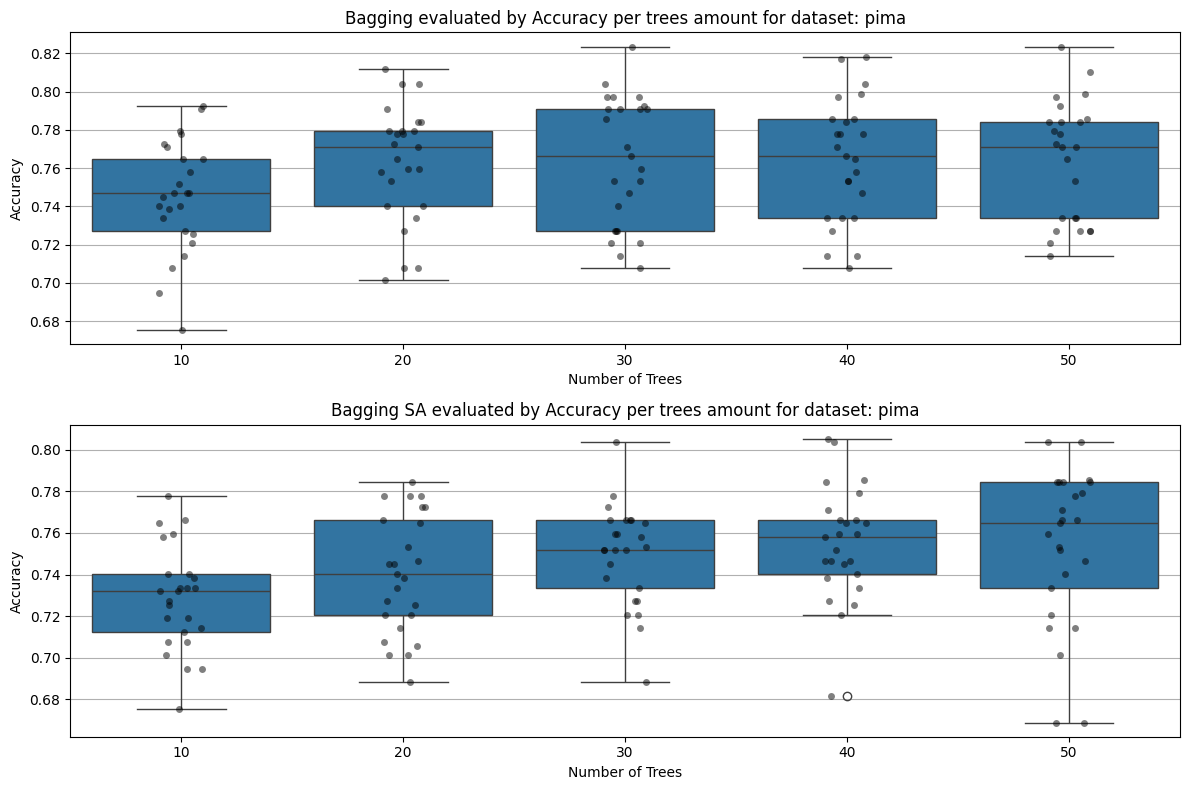

DATASET= pima | METRIC= Accuracy
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |  BaggingAccuracy   |     SAAccuracy     |  BaggingAccuracySTD  |    SAAccuracySTD     |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  pima   |   10   | 0.7450878533231474 | 0.7284101519395637 | 0.029035081032944752 | 0.024878254312654554 |
|  pima   |   20   | 0.7628096086919617 | 0.7404006451065274 | 0.030278128256664316 | 0.028604493982372154 |
|  pima   |   30   | 0.7638842203548086 | 0.7495051353874884 | 0.03367319999867683  | 0.024133119420812792 |
|  pima   |   40   | 0.764111705288176  | 0.7549630761395467 | 0.03188222669997819  | 0.02698744326544518  |
|  pima   |   50   | 0.7638621509209744 | 0.7531975214328156 | 0.031438783076732583 | 0.03752509974752971  |
+---------+--------+--------------------+--------------------+----------------------+----------

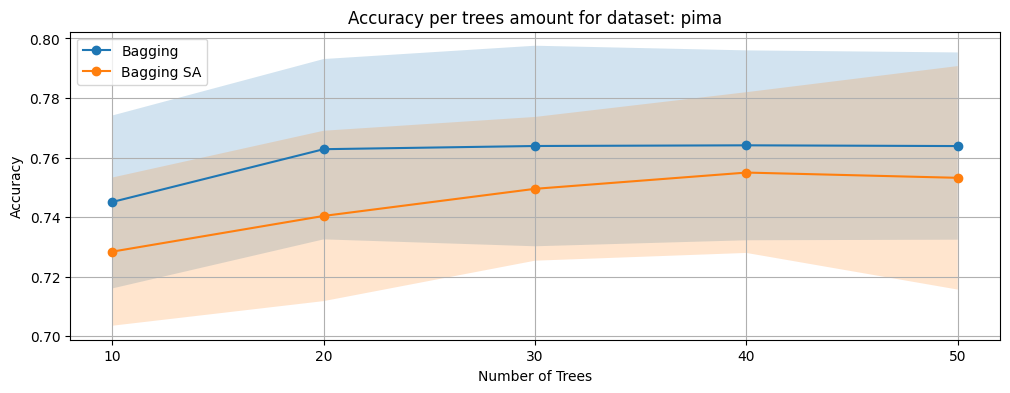

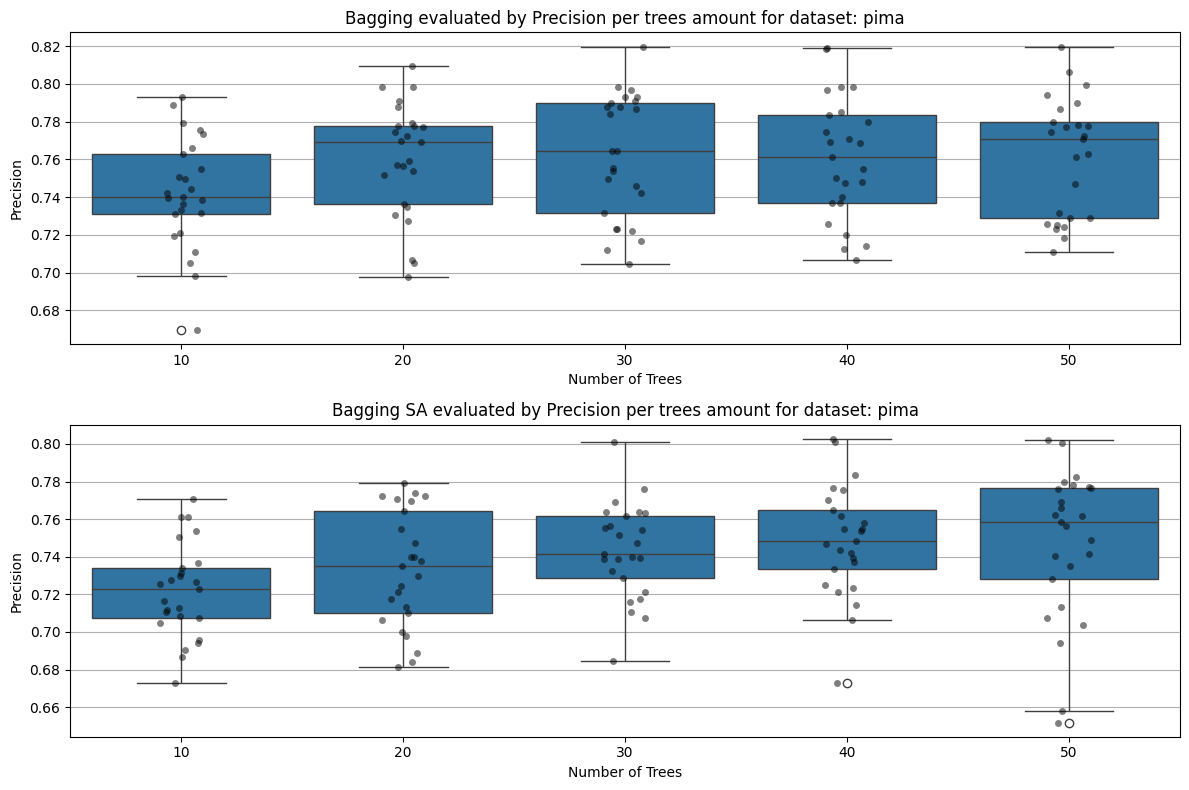

DATASET= pima | METRIC= Precision
+---------+--------+--------------------+--------------------+----------------------+---------------------+
| Dataset | nTrees |  BaggingPrecision  |    SAPrecision     | BaggingPrecisionSTD  |   SAPrecisionSTD    |
+---------+--------+--------------------+--------------------+----------------------+---------------------+
|  pima   |   10   | 0.7421919879128205 | 0.7216716338176478 | 0.029147860527069223 | 0.02502950466891752 |
|  pima   |   20   | 0.7599329000881143 | 0.7332311144451493 | 0.030198737577647173 | 0.03080854364759094 |
|  pima   |   30   | 0.7614158057851301 | 0.7431913600174748 | 0.03300468804472057  | 0.02521723581693133 |
|  pima   |   40   | 0.7606034929104726 | 0.7485003660114096 | 0.032291288913967924 | 0.02926343813163613 |
|  pima   |   50   | 0.7604702413108819 | 0.7467379906967793 | 0.03153694713906214  | 0.03992109821441292 |
+---------+--------+--------------------+--------------------+----------------------+-----------------

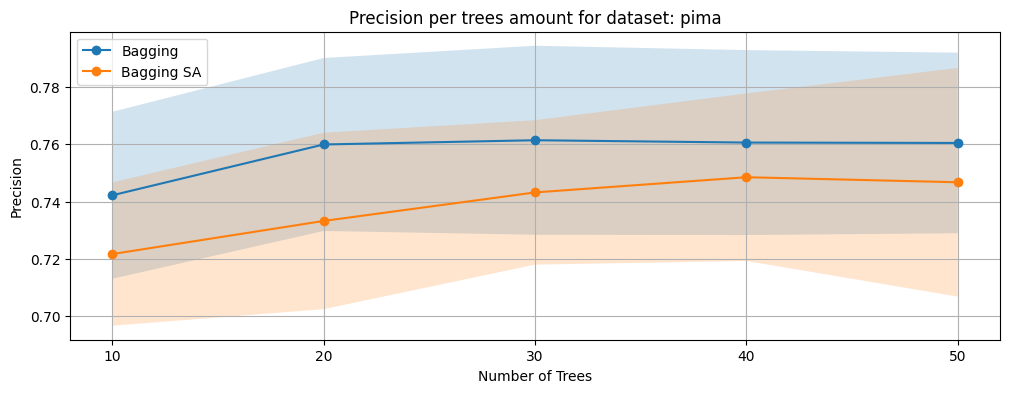

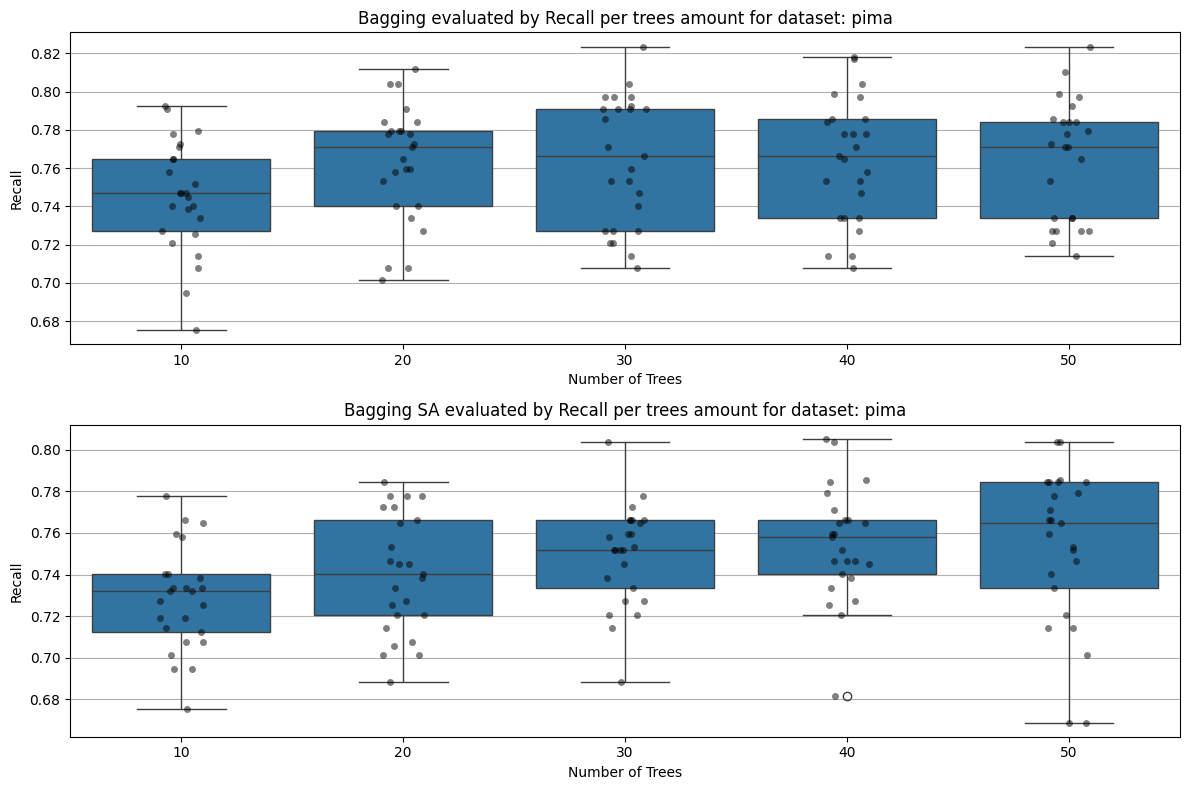

DATASET= pima | METRIC= Recall
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |   BaggingRecall    |      SARecall      |   BaggingRecallSTD   |     SARecallSTD      |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  pima   |   10   | 0.7450878533231474 | 0.7284101519395637 | 0.029035081032944752 | 0.024878254312654554 |
|  pima   |   20   | 0.7628096086919617 | 0.7404006451065274 | 0.030278128256664316 | 0.028604493982372154 |
|  pima   |   30   | 0.7638842203548086 | 0.7495051353874884 | 0.03367319999867683  | 0.024133119420812792 |
|  pima   |   40   | 0.764111705288176  | 0.7549630761395467 | 0.03188222669997819  | 0.02698744326544518  |
|  pima   |   50   | 0.7638621509209744 | 0.7531975214328156 | 0.031438783076732583 | 0.03752509974752971  |
+---------+--------+--------------------+--------------------+----------------------+------------

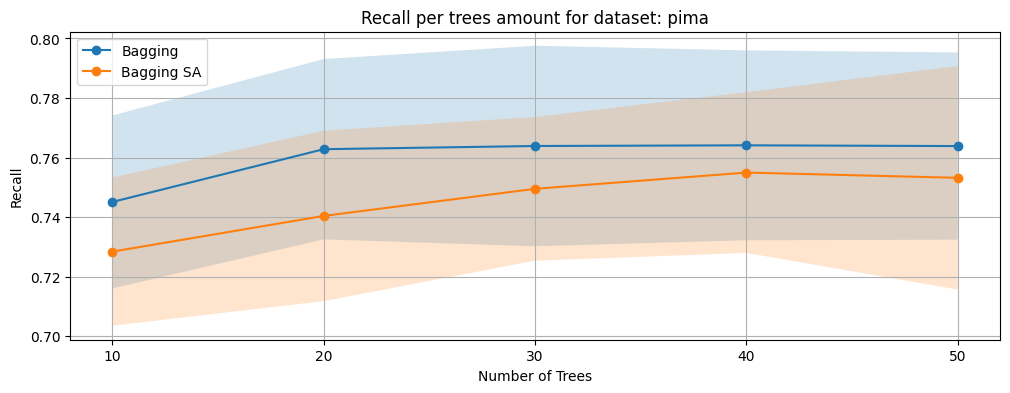

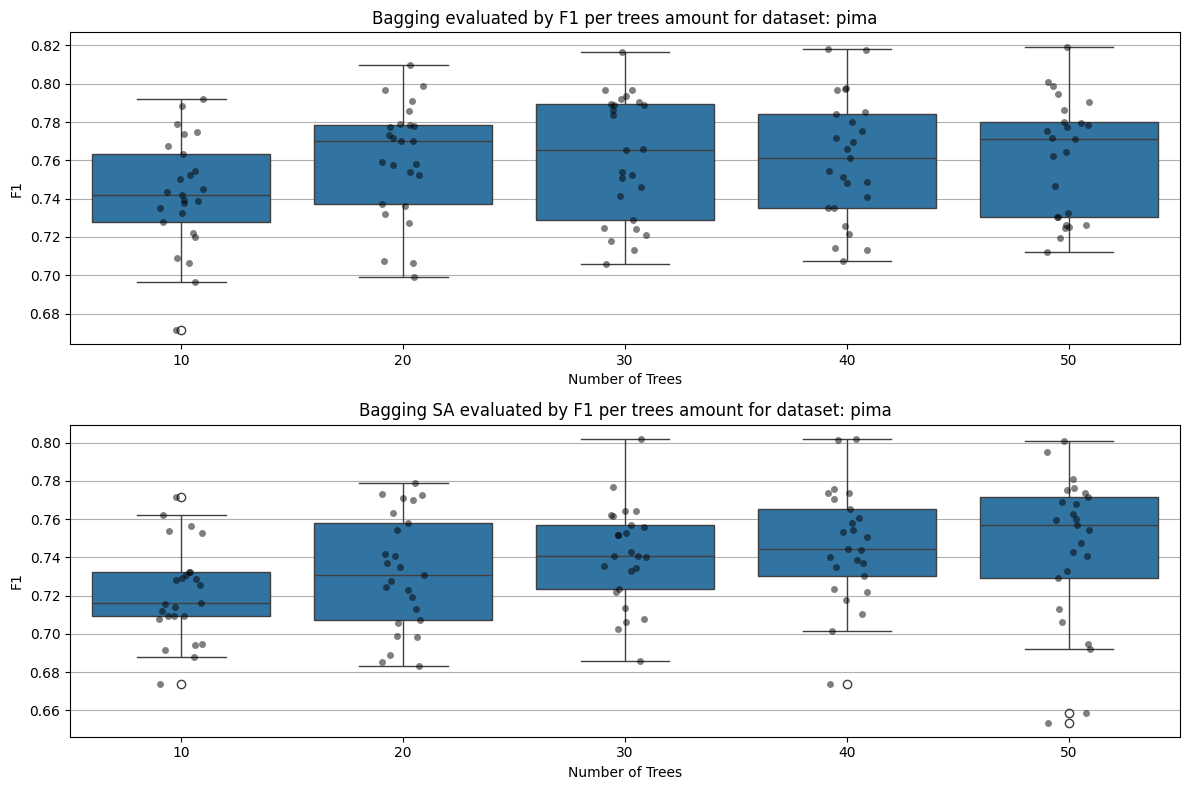

DATASET= pima | METRIC= F1
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |     BaggingF1      |        SAF1        |     BaggingF1STD     |       SAF1STD        |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  pima   |   10   | 0.7425747865082027 | 0.7216232986098788 | 0.029039209269411236 | 0.02455786118097298  |
|  pima   |   20   | 0.7602463607470203 | 0.7320871529949082 | 0.029732489241538596 | 0.029940455390796216 |
|  pima   |   30   | 0.7613658968550377 | 0.7411919449239457 | 0.032513402657107844 | 0.025979299178399598 |
|  pima   |   40   | 0.7606713715014891 | 0.746270390976019  | 0.03213111311204284  | 0.02960017586475014  |
|  pima   |   50   | 0.7609882744509341 | 0.7446397475019864 | 0.03087770848146879  | 0.039035182058222144 |
+---------+--------+--------------------+--------------------+----------------------+----------------

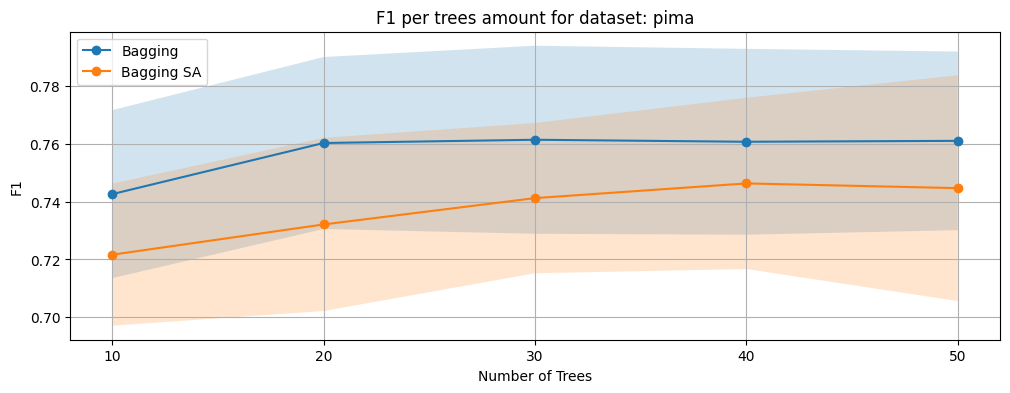

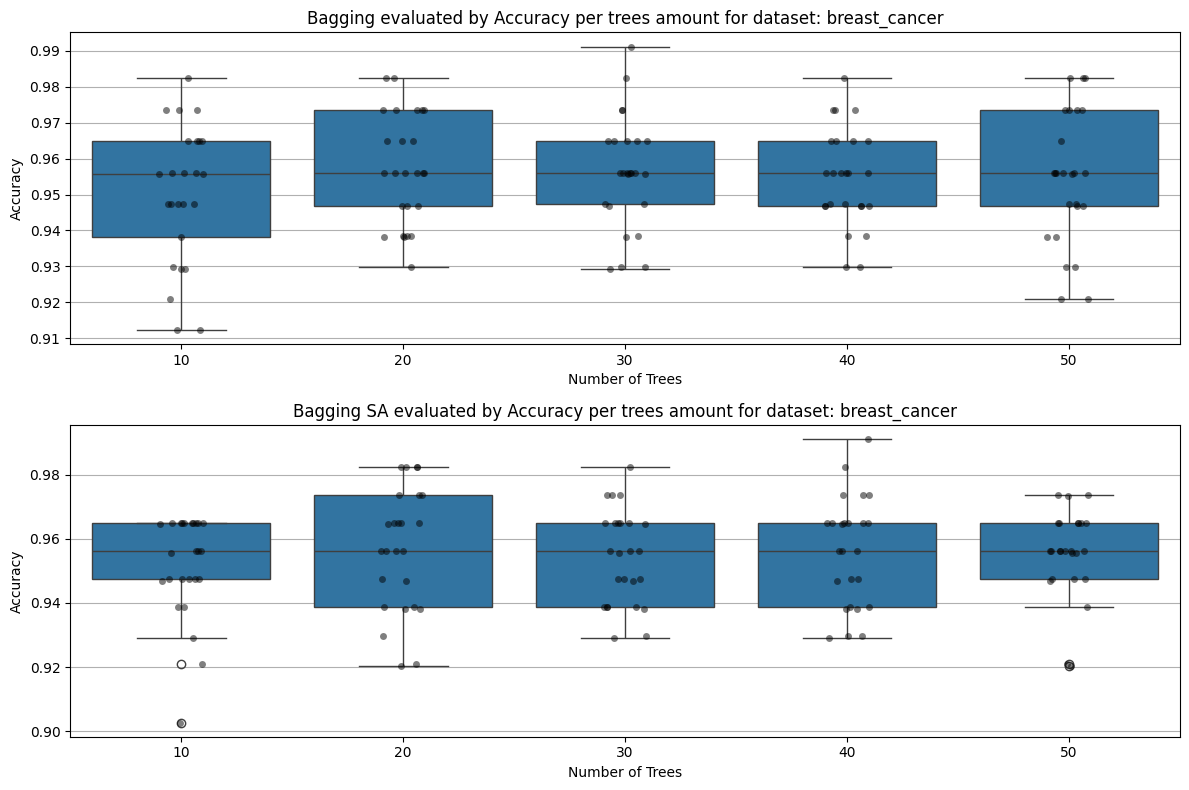

DATASET= breast_cancer | METRIC= Accuracy
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
|    Dataset    | nTrees |  BaggingAccuracy   |     SAAccuracy     |  BaggingAccuracySTD  |    SAAccuracySTD     |
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
| breast_cancer |   10   | 0.9500729700357087 | 0.9514733736997362 | 0.01929779231208628  | 0.015972410781093786 |
| breast_cancer |   20   | 0.9570936190032604 | 0.9567396367023754 | 0.015354536838902973 | 0.019039798726975365 |
| breast_cancer |   30   | 0.9560440925322155 | 0.9542928116752057 | 0.015690819894974527 |  0.0148318512097577  |
| breast_cancer |   40   | 0.9546436888681882 | 0.9560409874243131 | 0.013615024038298314 | 0.01707799819312604  |
| breast_cancer |   50   | 0.9546405837602857 | 0.9553516534699581 | 0.01843431348225226  | 0.013689182440123873 |
+---------------+--------+------------

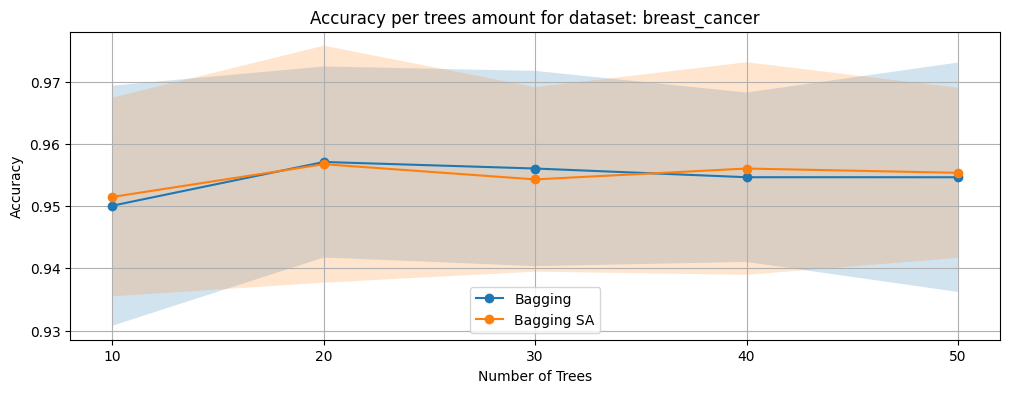

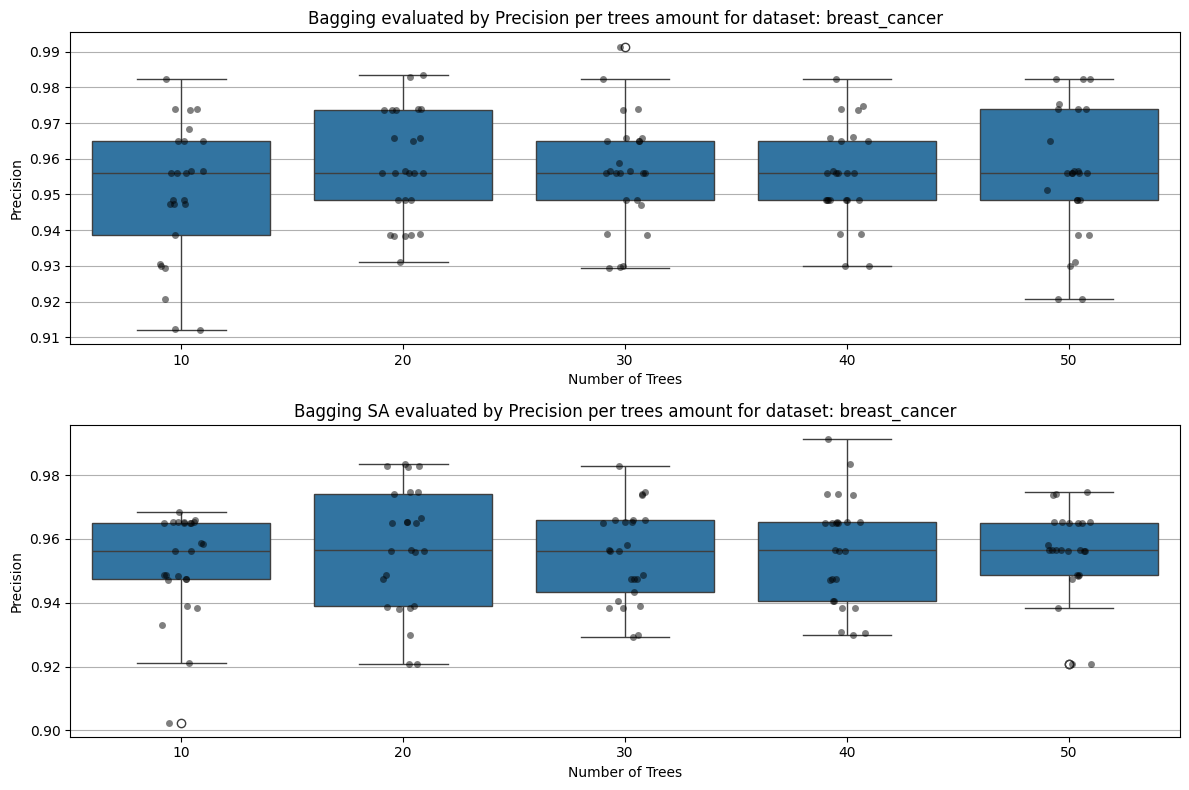

DATASET= breast_cancer | METRIC= Precision
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
|    Dataset    | nTrees |  BaggingPrecision  |    SAPrecision     | BaggingPrecisionSTD  |    SAPrecisionSTD    |
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
| breast_cancer |   10   | 0.9504477456018442 | 0.9522417584811348 | 0.019420607971042742 | 0.01602857855647857  |
| breast_cancer |   20   | 0.9575528403747167 | 0.9571274618539668 | 0.01522404243726139  | 0.019193015022553623 |
| breast_cancer |   30   | 0.9564396664886047 | 0.9550184495047125 | 0.015674715035713046 | 0.014737424767812975 |
| breast_cancer |   40   | 0.9552258417167389 | 0.956464937289589  | 0.013484098361841937 | 0.016844155135185928 |
| breast_cancer |   50   | 0.9551958916565553 | 0.9558042490919522 | 0.018353740023603057 | 0.01370258483710505  |
+---------------+--------+-----------

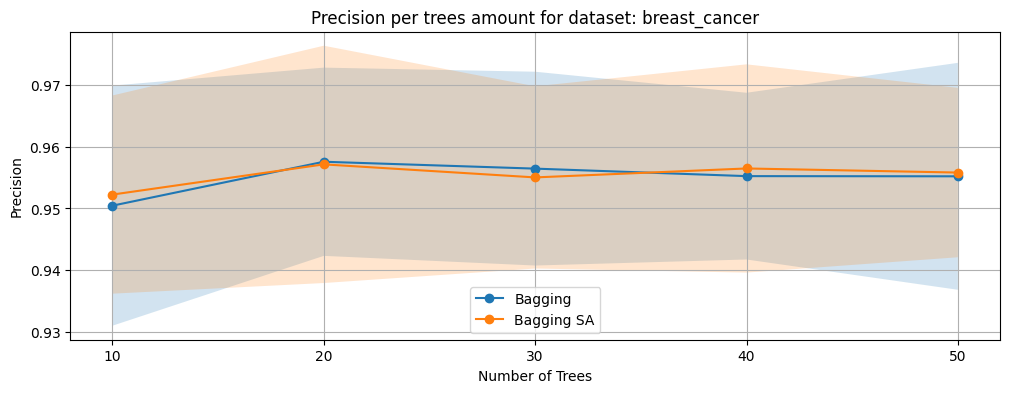

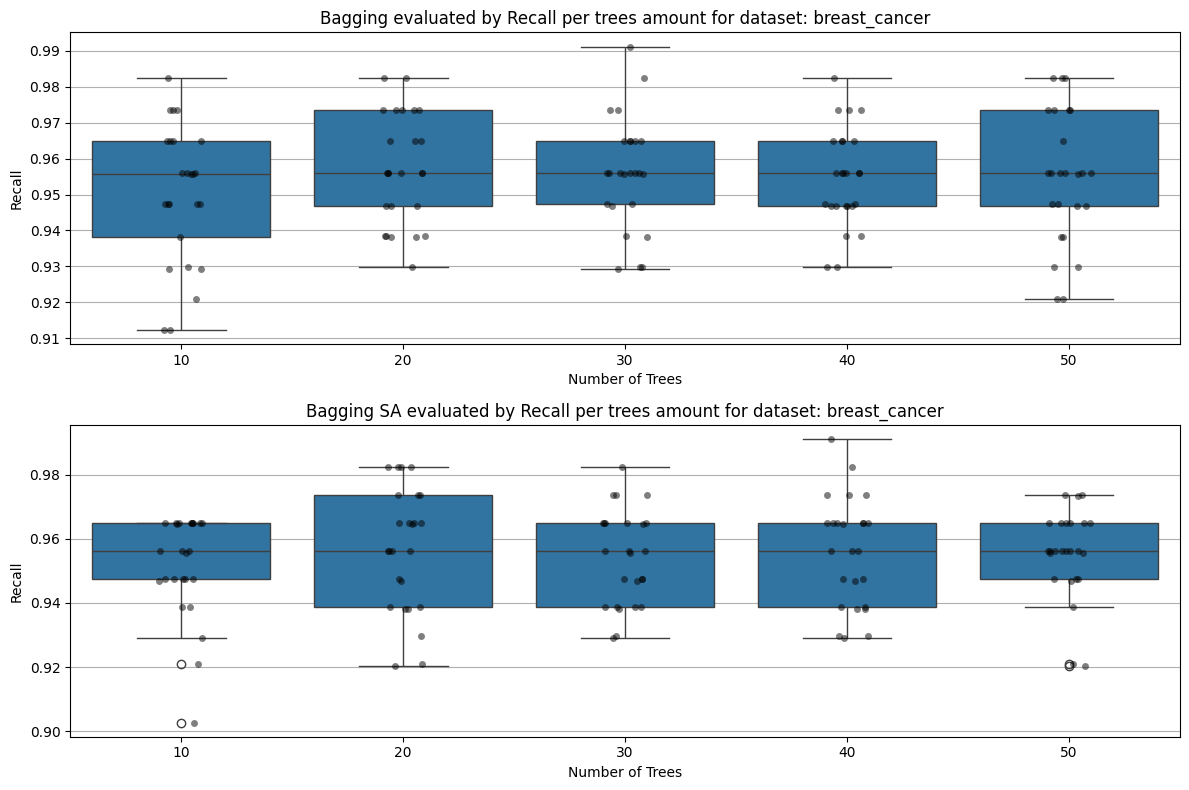

DATASET= breast_cancer | METRIC= Recall
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
|    Dataset    | nTrees |   BaggingRecall    |      SARecall      |   BaggingRecallSTD   |     SARecallSTD      |
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
| breast_cancer |   10   | 0.9500729700357087 | 0.9514733736997362 | 0.01929779231208628  | 0.015972410781093786 |
| breast_cancer |   20   | 0.9570936190032604 | 0.9567396367023754 | 0.015354536838902973 | 0.019039798726975365 |
| breast_cancer |   30   | 0.9560440925322155 | 0.9542928116752057 | 0.015690819894974527 |  0.0148318512097577  |
| breast_cancer |   40   | 0.9546436888681882 | 0.9560409874243131 | 0.013615024038298314 | 0.01707799819312604  |
| breast_cancer |   50   | 0.9546405837602857 | 0.9553516534699581 | 0.01843431348225226  | 0.013689182440123873 |
+---------------+--------+--------------

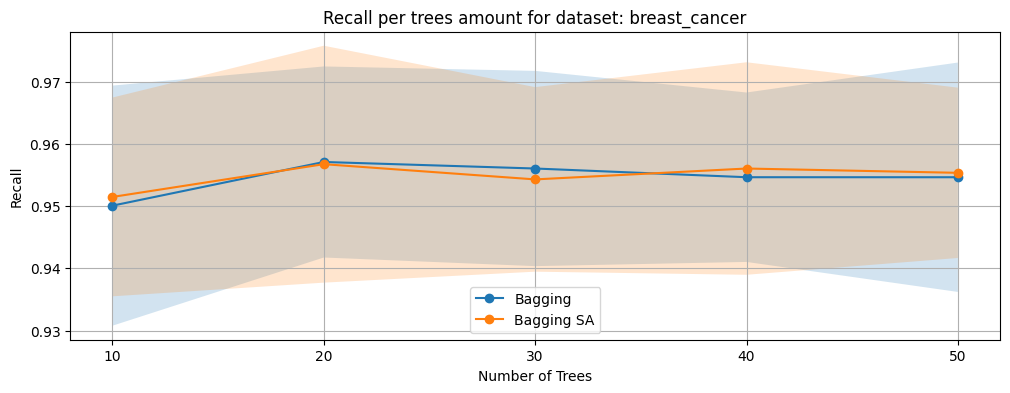

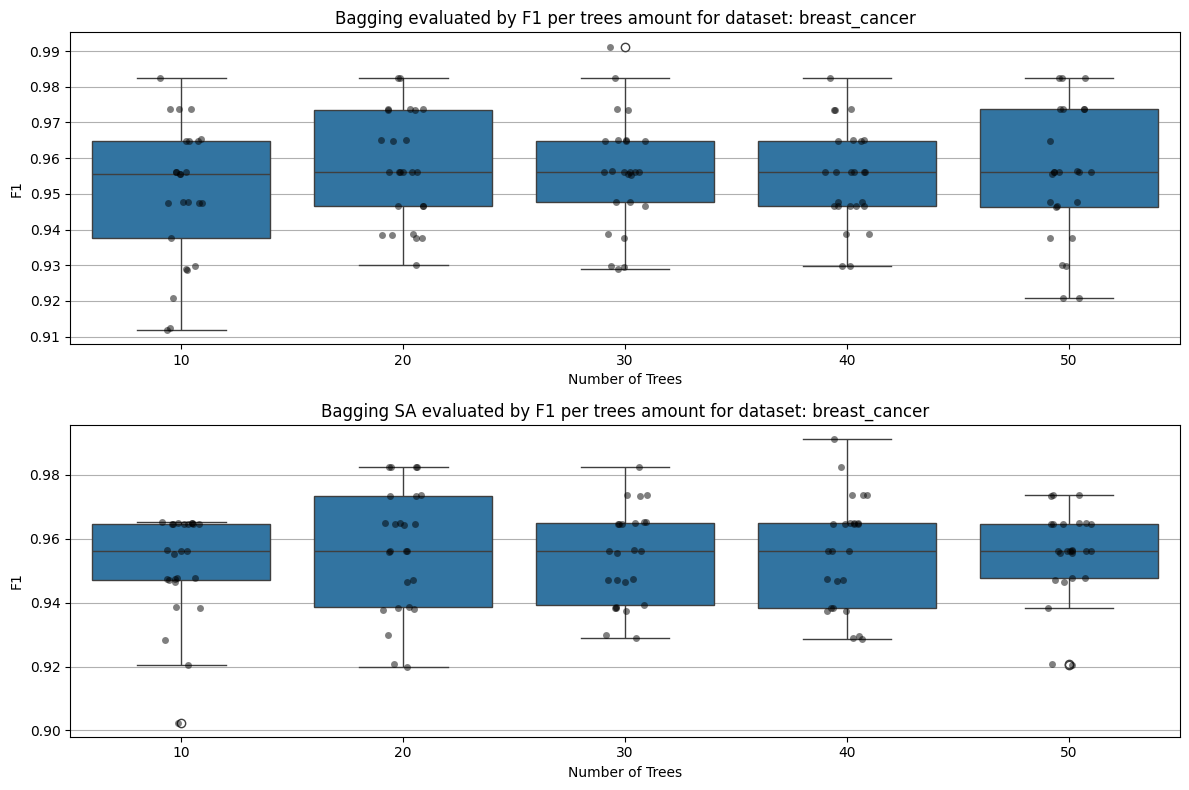

DATASET= breast_cancer | METRIC= F1
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
|    Dataset    | nTrees |     BaggingF1      |        SAF1        |     BaggingF1STD     |       SAF1STD        |
+---------------+--------+--------------------+--------------------+----------------------+----------------------+
| breast_cancer |   10   | 0.9500044064510988 | 0.9513618271788671 | 0.019398830324253408 | 0.016084227240846582 |
| breast_cancer |   20   | 0.9570073252616471 | 0.9566095535175027 | 0.015417336368753934 | 0.01909517215323075  |
| breast_cancer |   30   | 0.9559871892121352 | 0.9542168398743983 | 0.015749318250323826 | 0.014865700065175885 |
| breast_cancer |   40   | 0.9545692378163656 | 0.9558650228791621 | 0.01363549102072849  | 0.017260964413570678 |
| breast_cancer |   50   | 0.9545689800348424 | 0.9552899265061968 | 0.018501674167931144 |  0.0136742262850727  |
+---------------+--------+------------------

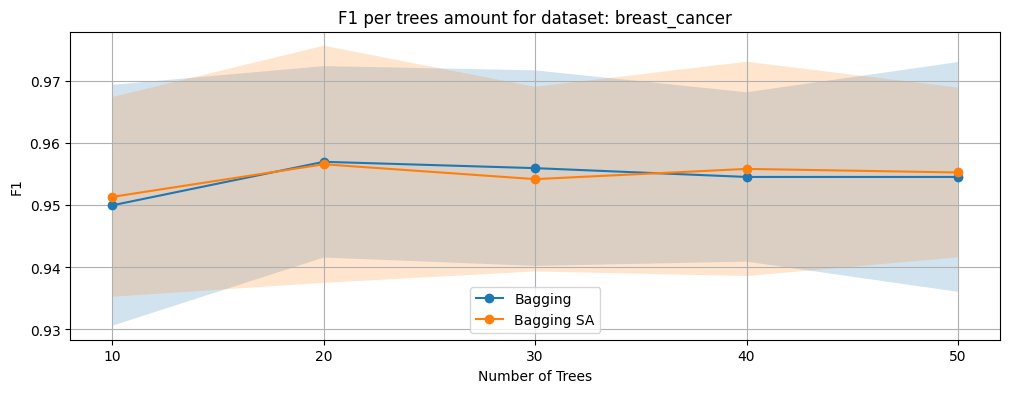

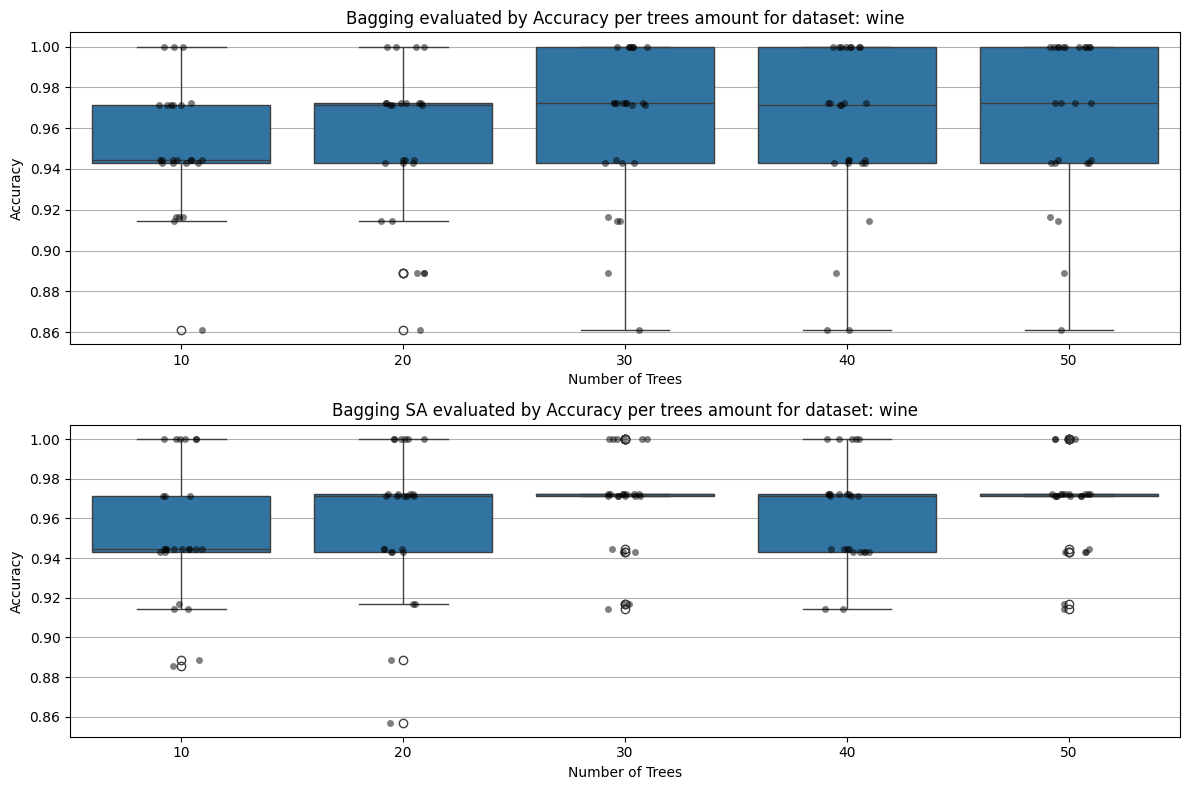

DATASET= wine | METRIC= Accuracy
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |  BaggingAccuracy   |     SAAccuracy     |  BaggingAccuracySTD  |    SAAccuracySTD     |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  wine   |   10   | 0.9494920634920635 | 0.9527936507936507 | 0.031100311266612016 | 0.03421233328867205  |
|  wine   |   20   | 0.9506349206349206 | 0.9594920634920635 | 0.03885445511505379  | 0.036425516580653544 |
|  wine   |   30   | 0.9606666666666667 | 0.9684761904761905 | 0.037921284940201014 | 0.026067451960908542 |
|  wine   |   40   | 0.9584761904761905 | 0.9627301587301588 | 0.04193584004691067  | 0.025591884854788652 |
|  wine   |   50   | 0.9652063492063492 | 0.9684126984126984 | 0.039782070945644336 | 0.023541257658148157 |
+---------+--------+--------------------+--------------------+----------------------+----------

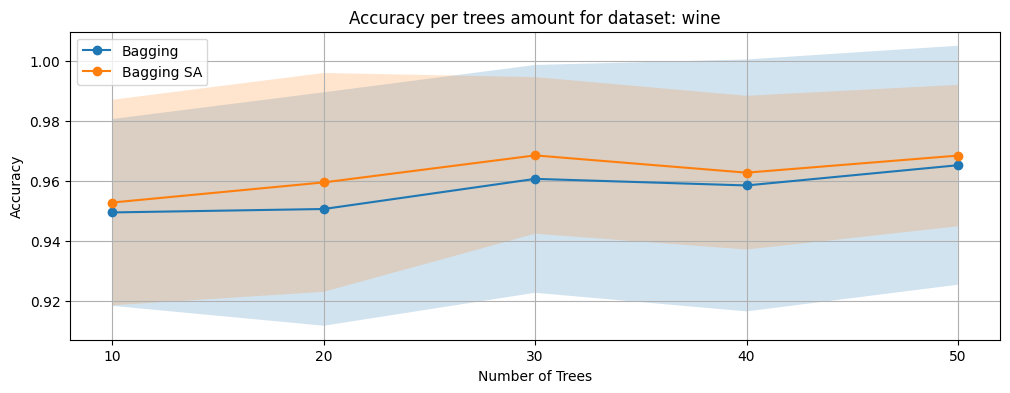

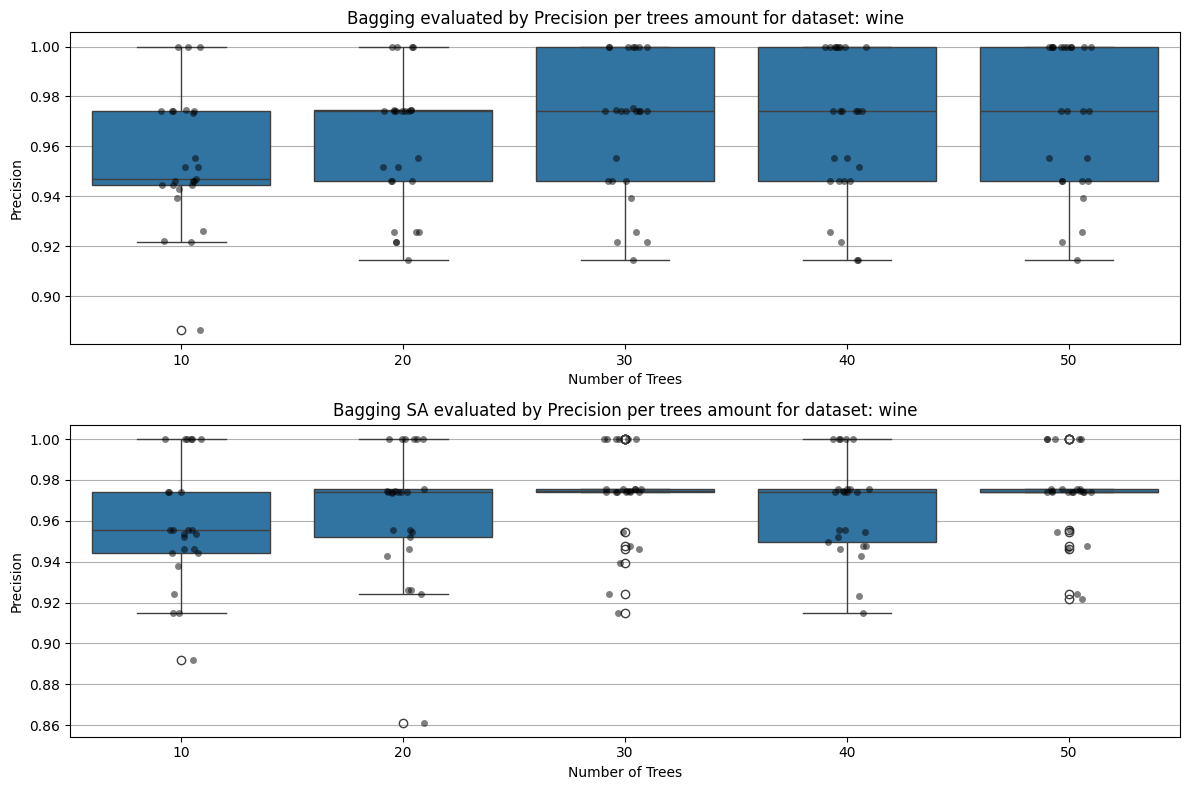

DATASET= wine | METRIC= Precision
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |  BaggingPrecision  |    SAPrecision     | BaggingPrecisionSTD  |    SAPrecisionSTD    |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  wine   |   10   | 0.9544366582276799 | 0.9587296140678494 | 0.026595267339539368 | 0.030076816136791067 |
|  wine   |   20   | 0.9600672845672845 | 0.9644955231670771 | 0.026947464160104895 | 0.03219686968806509  |
|  wine   |   30   | 0.9674456716123382 | 0.9718801426968093 | 0.028010785700232202 | 0.023264209507601784 |
|  wine   |   40   | 0.9667523587523587 | 0.9664833375774552 | 0.029224915270323962 | 0.023572841726587603 |
|  wine   |   50   | 0.9717507677507677 | 0.9717195070361737 | 0.02949814552019157  | 0.021078018673079197 |
+---------+--------+--------------------+--------------------+----------------------+---------

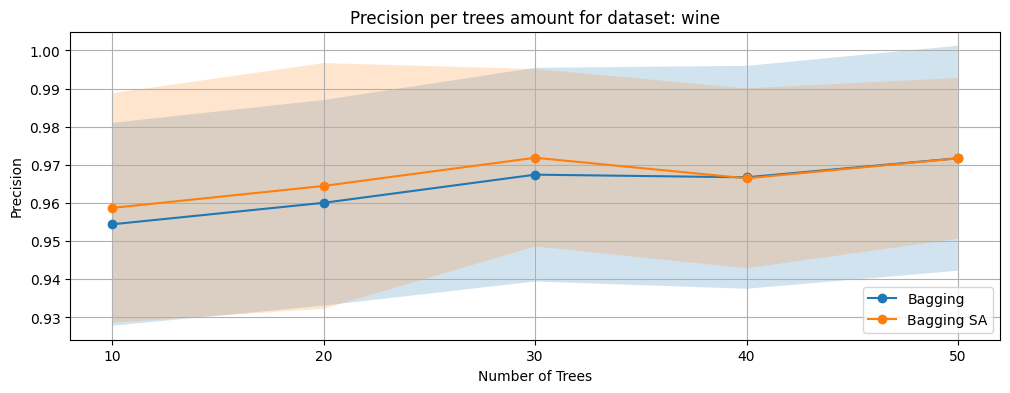

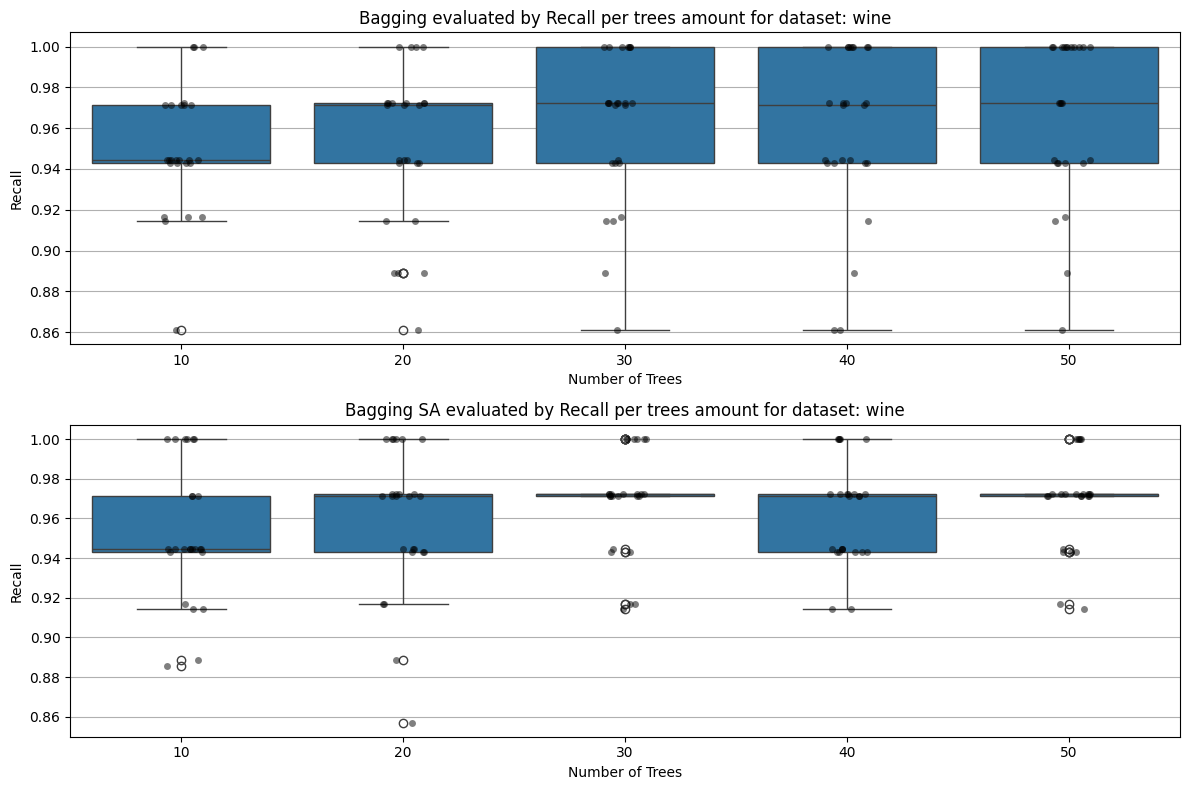

DATASET= wine | METRIC= Recall
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |   BaggingRecall    |      SARecall      |   BaggingRecallSTD   |     SARecallSTD      |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  wine   |   10   | 0.9494920634920635 | 0.9527936507936507 | 0.031100311266612016 | 0.03421233328867205  |
|  wine   |   20   | 0.9506349206349206 | 0.9594920634920635 | 0.03885445511505379  | 0.036425516580653544 |
|  wine   |   30   | 0.9606666666666667 | 0.9684761904761905 | 0.037921284940201014 | 0.026067451960908542 |
|  wine   |   40   | 0.9584761904761905 | 0.9627301587301588 | 0.04193584004691067  | 0.025591884854788652 |
|  wine   |   50   | 0.9652063492063492 | 0.9684126984126984 | 0.039782070945644336 | 0.023541257658148157 |
+---------+--------+--------------------+--------------------+----------------------+------------

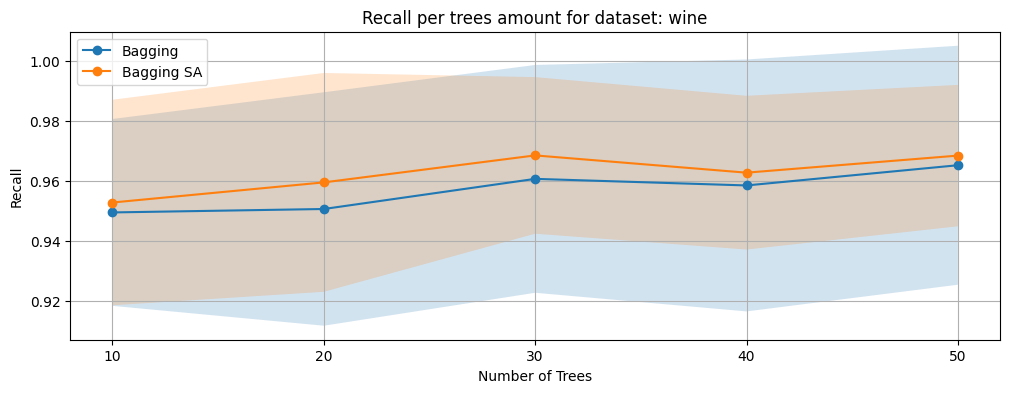

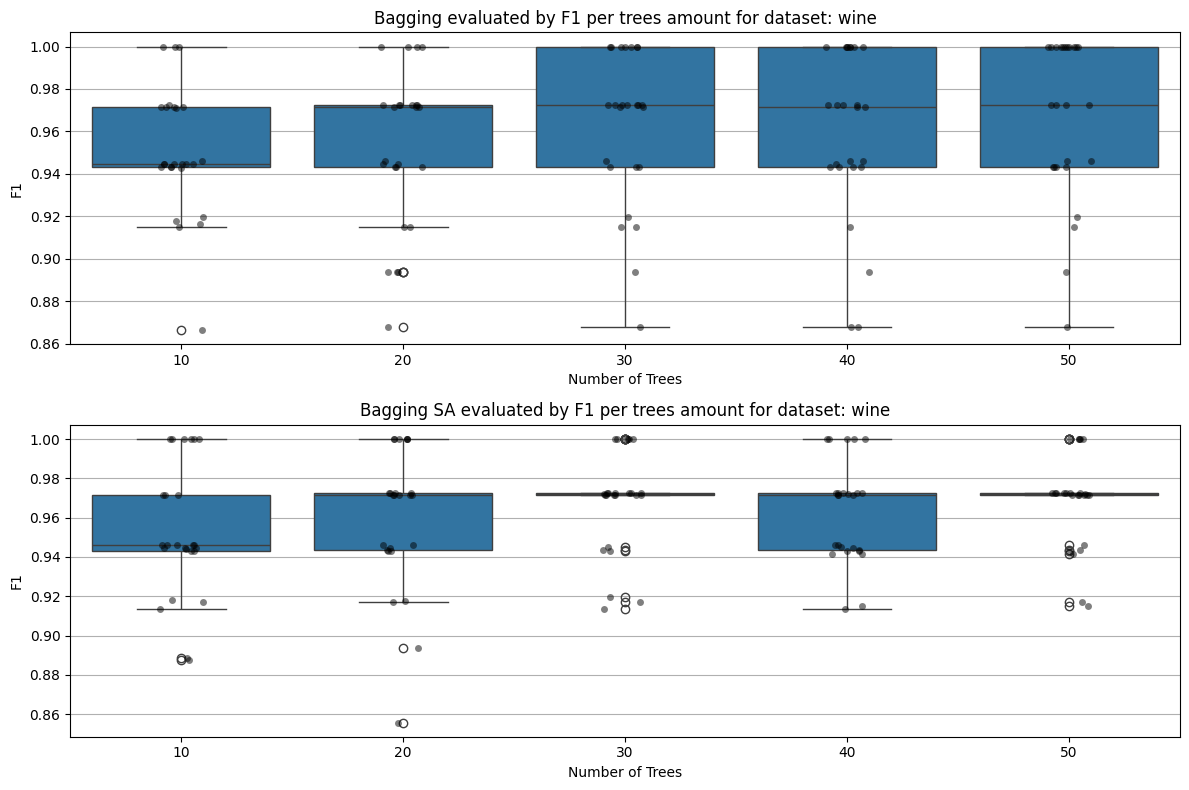

DATASET= wine | METRIC= F1
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |     BaggingF1      |        SAF1        |     BaggingF1STD     |       SAF1STD        |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
|  wine   |   10   | 0.950027446341131  | 0.9533453038611627 | 0.03028133858143586  | 0.03387494844975181  |
|  wine   |   20   | 0.9516959310485421 | 0.9599370431866668 | 0.03721822980469905  | 0.036069237010112075 |
|  wine   |   30   | 0.9614562993413426 | 0.9687765213020261 | 0.036580886757747816 | 0.025809799462388684 |
|  wine   |   40   | 0.9594398884997577 | 0.9629012302830233 | 0.040244944327170754 | 0.02559548422311385  |
|  wine   |   50   | 0.9660132158179644 | 0.9686360716363775 | 0.03838608390319645  | 0.02340760629570282  |
+---------+--------+--------------------+--------------------+----------------------+----------------

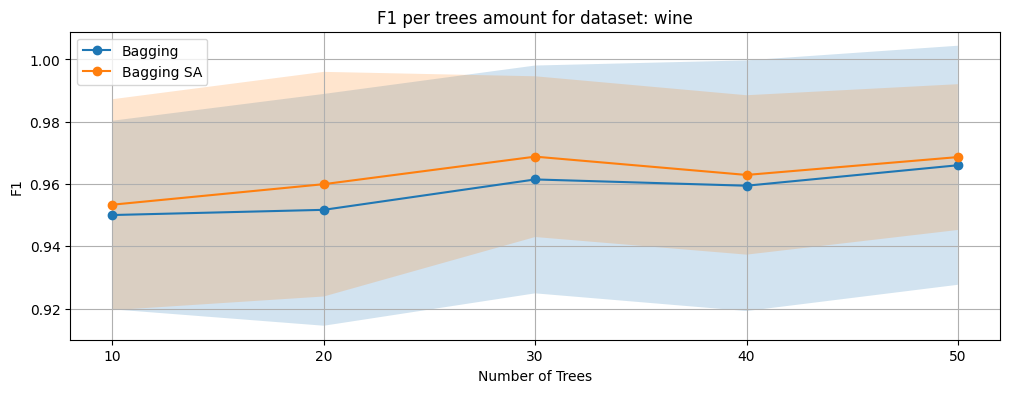

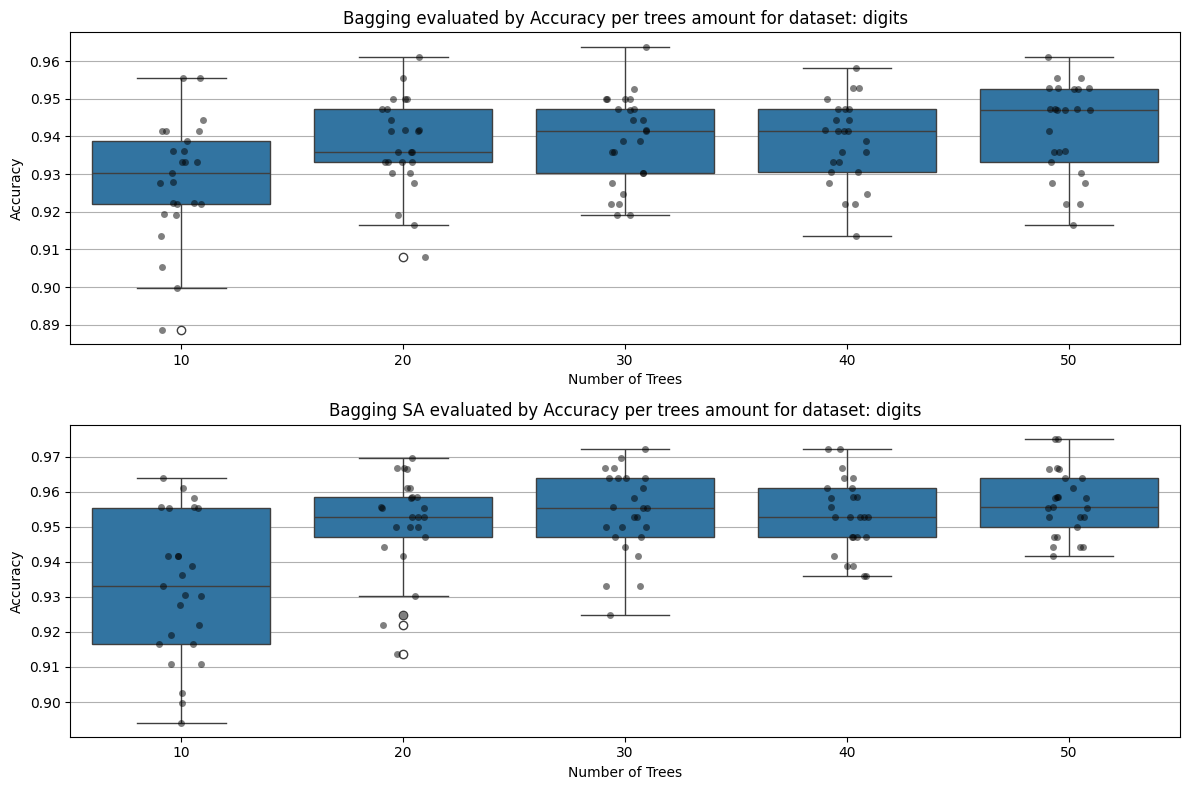

DATASET= digits | METRIC= Accuracy
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |  BaggingAccuracy   |     SAAccuracy     |  BaggingAccuracySTD  |    SAAccuracySTD     |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| digits  |   10   | 0.9284311358712474 | 0.9327613741875581 | 0.015843632086564505 | 0.020515235874037644 |
| digits  |   20   | 0.9377765397709688 | 0.9505756731662024 | 0.012198648984862063 | 0.014433998514852492 |
| digits  |   30   | 0.9389990714948933 | 0.9536898792943361 | 0.011940355140470352 | 0.012035010670396126 |
| digits  |   40   | 0.9383348808418447 | 0.9533574744661095 | 0.011045263178248811 | 0.010491949578409536 |
| digits  |   50   | 0.9418932219127205 | 0.9565908387496131 | 0.012346168421669365 | 0.009282424499107322 |
+---------+--------+--------------------+--------------------+----------------------+--------

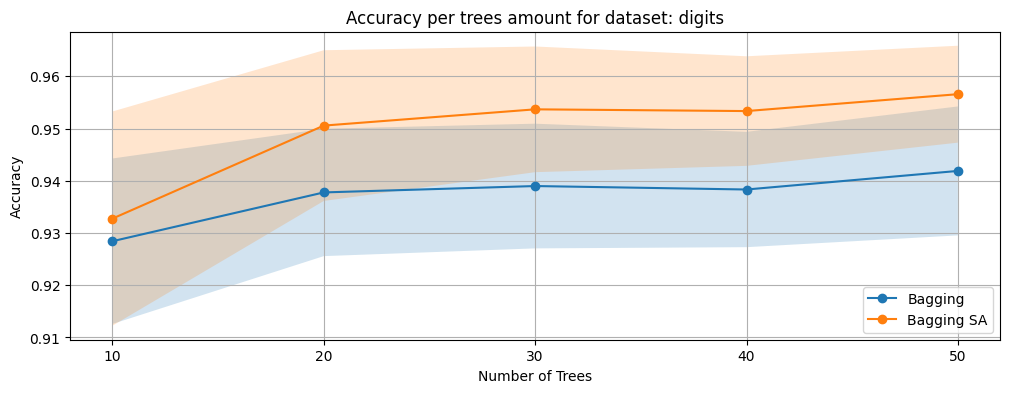

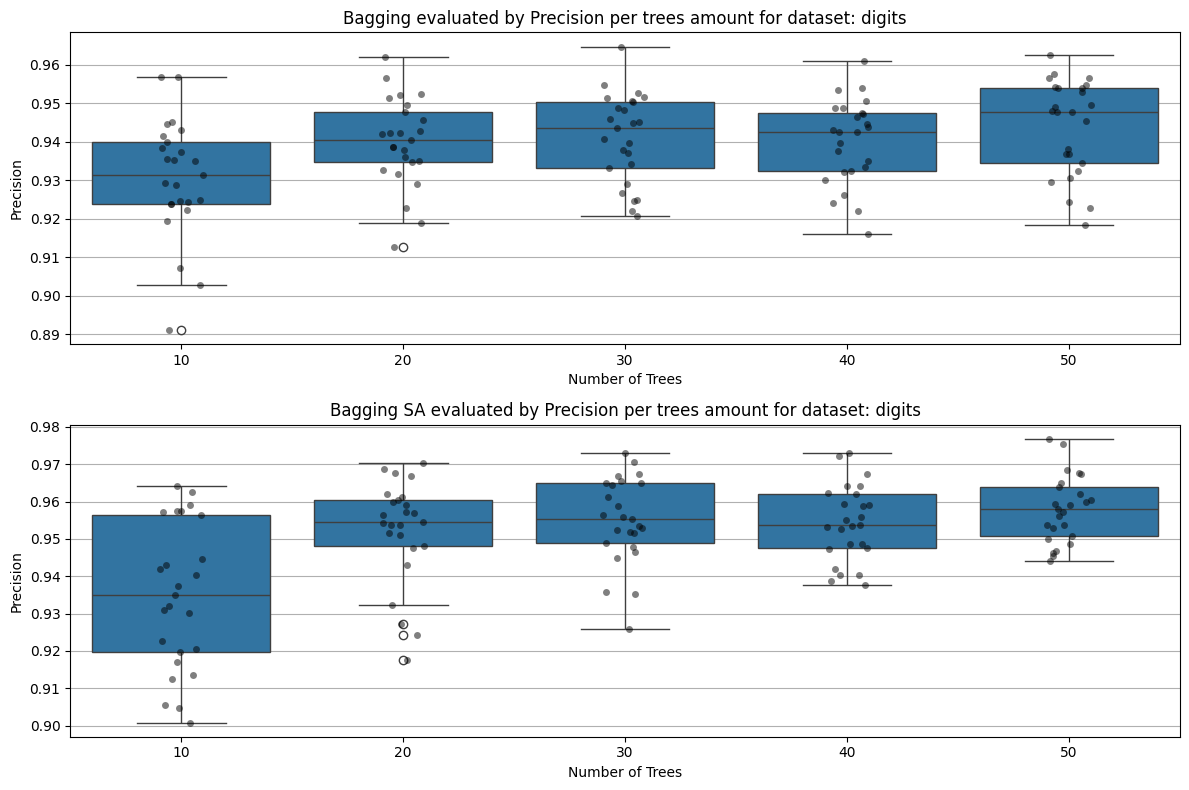

DATASET= digits | METRIC= Precision
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |  BaggingPrecision  |    SAPrecision     | BaggingPrecisionSTD  |    SAPrecisionSTD    |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| digits  |   10   | 0.9305117006685033 | 0.9346569827564184 | 0.01524146492688391  | 0.019663788003406638 |
| digits  |   20   | 0.9398000262871932 | 0.9522166644889648 | 0.011534516446641354 | 0.013881979318504092 |
| digits  |   30   | 0.9408985700728033 | 0.9549294825206932 | 0.011618465419227163 | 0.011595805930463473 |
| digits  |   40   | 0.9400886993928456 | 0.9542905972581355 | 0.010991049376556962 | 0.010119061095066825 |
| digits  |   50   | 0.9437960883402977 | 0.9579733536153608 | 0.012406628413324737 | 0.008986129434039185 |
+---------+--------+--------------------+--------------------+----------------------+-------

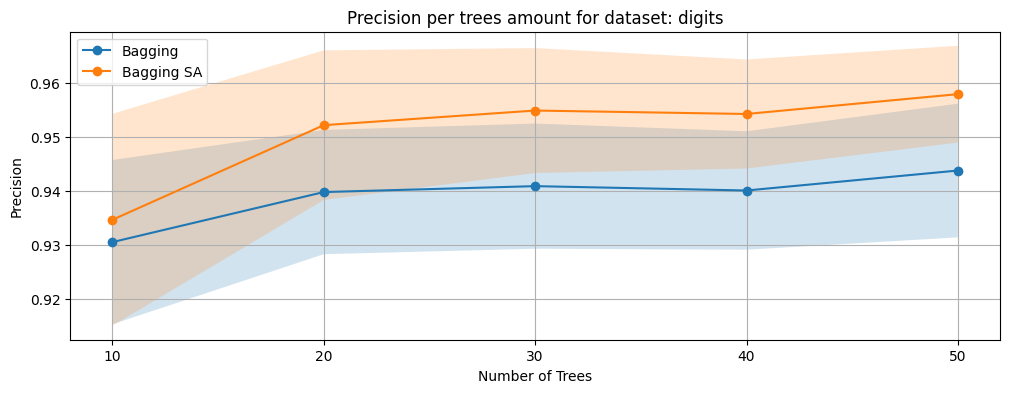

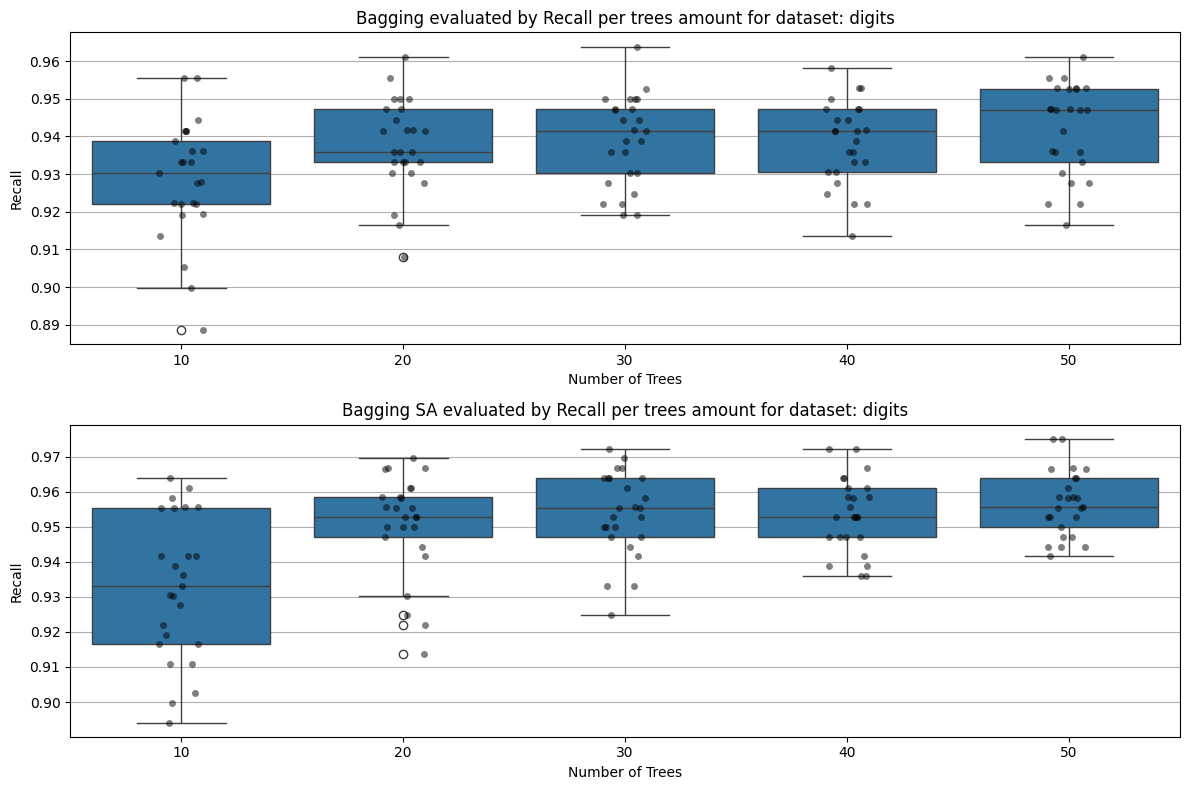

DATASET= digits | METRIC= Recall
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |   BaggingRecall    |      SARecall      |   BaggingRecallSTD   |     SARecallSTD      |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| digits  |   10   | 0.9284311358712474 | 0.9327613741875581 | 0.015843632086564505 | 0.020515235874037644 |
| digits  |   20   | 0.9377765397709688 | 0.9505756731662024 | 0.012198648984862063 | 0.014433998514852492 |
| digits  |   30   | 0.9389990714948933 | 0.9536898792943361 | 0.011940355140470352 | 0.012035010670396126 |
| digits  |   40   | 0.9383348808418447 | 0.9533574744661095 | 0.011045263178248811 | 0.010491949578409536 |
| digits  |   50   | 0.9418932219127205 | 0.9565908387496131 | 0.012346168421669365 | 0.009282424499107322 |
+---------+--------+--------------------+--------------------+----------------------+----------

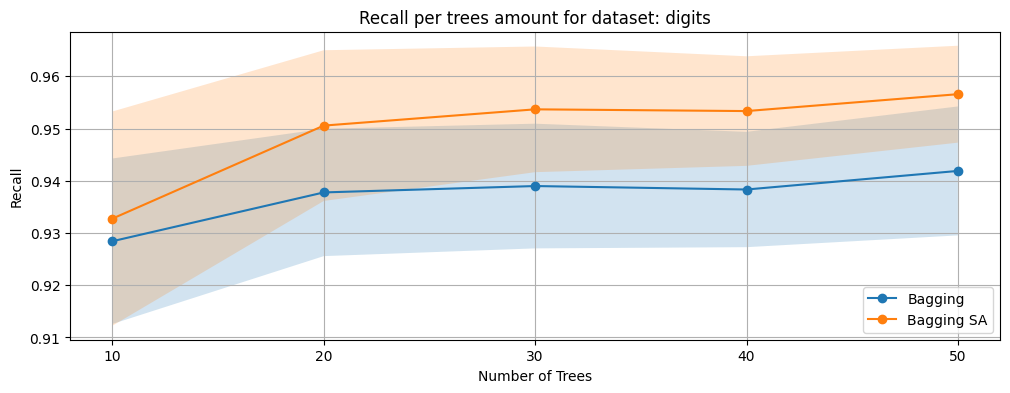

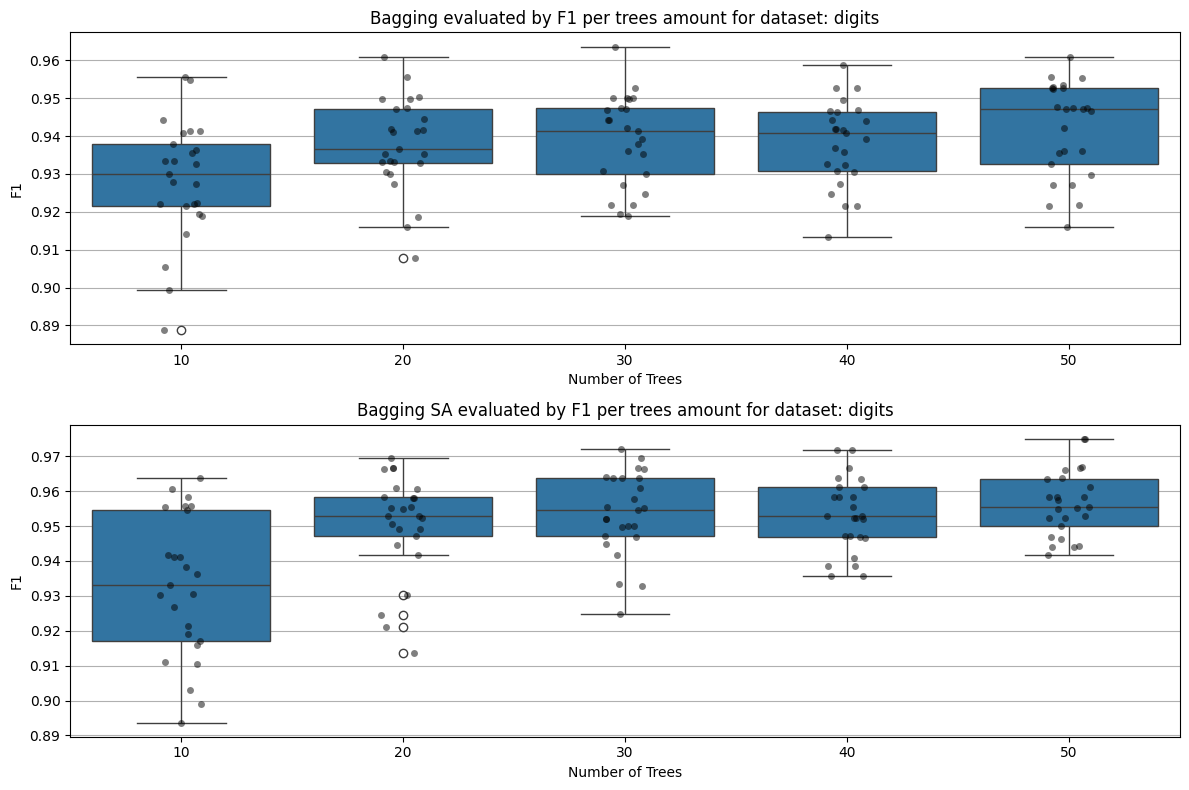

DATASET= digits | METRIC= F1
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| Dataset | nTrees |     BaggingF1      |        SAF1        |     BaggingF1STD     |       SAF1STD        |
+---------+--------+--------------------+--------------------+----------------------+----------------------+
| digits  |   10   | 0.9282711582599857 | 0.9325594275572449 | 0.015719611805196283 | 0.020535136631626816 |
| digits  |   20   | 0.9376515645411359 | 0.9504438226252033 | 0.012300555879953512 | 0.01448632587936204  |
| digits  |   30   | 0.938886486182584  | 0.953570144680466  | 0.011990928739026959 | 0.011982333362274713 |
| digits  |   40   | 0.938176499227772  | 0.9531743506753309 | 0.011100204882976968 | 0.010508023832088202 |
| digits  |   50   | 0.9417663636951084 | 0.9564338178484743 | 0.012551917467803016 | 0.009336638977584993 |
+---------+--------+--------------------+--------------------+----------------------+--------------

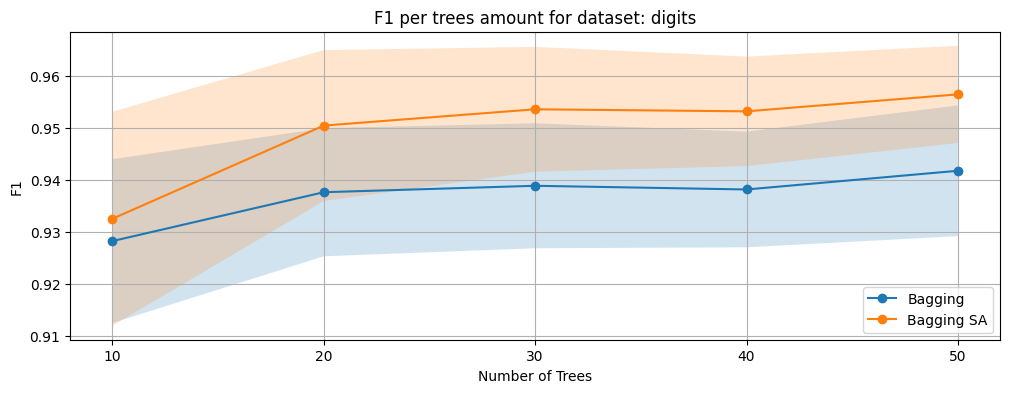

In [85]:

files = glob.glob('./../res/metrics_*.csv')
dfs = [pd.read_csv(f) for f in files]


metrics = ["Accuracy", "Precision", "Recall", "F1"]

for df in dfs:
    for metric in metrics:
        df_aggregated = df.groupby(['nTrees']).agg({
            'Dataset': 'first',
            'nTrees': 'first',
            f'Bagging{metric}': 'mean',
            f'SA{metric}': 'mean',
        }).reset_index(drop=True)
        
        dataset = df_aggregated['Dataset'].values[0]
        
        df_aggregated[f'Bagging{metric}STD'] = df.groupby(['nTrees'])[f'Bagging{metric}'].std().values
        df_aggregated[f'SA{metric}STD'] = df.groupby(['nTrees'])[f'SA{metric}'].std().values
                
        create_box_plots(df, metric, path=f'./../report/boxplot_{dataset}_{metric}.png')
        print(f"DATASET= {dataset} | METRIC= {metric}")
        print(tabulate(df_aggregated, headers='keys', tablefmt='pretty', showindex=False))
        print(f"STATS")
        stats = stat_tests(df, metric)
        print(tabulate(stats, headers='keys', tablefmt='pretty', showindex=False))
        create_comparison_plot(df_aggregated, metric, path=f'./../report/plot_{dataset}_{metric}.png')
        df_aggregated.to_csv(f'./../report/metrics_{dataset}_{metric}.csv', index=False)
        stats.to_csv(f'./../report/stats_{dataset}_{metric}.csv', index=False)
        